# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ac      1206 non-null   int64 
 1   int     1206 non-null   int64 
 2   book    1206 non-null   object
 3   level   1206 non-null   int64 
 4   str     1206 non-null   int64 
 5   dex     1206 non-null   int64 
 6   hp      1206 non-null   int64 
 7   cha     1206 non-null   int64 
 8   wis     1206 non-null   int64 
 9   con     1206 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 103.6+ KB


In [3]:
df.head()

,ac,int,book,level,str,dex,hp,cha,wis,con
0,29,1,Pathfinder Bestiary,10,7,2,215,1,2,5
1,28,-4,Pathfinder Bestiary,10,9,0,220,1,2,5
2,25,-4,Pathfinder Bestiary,8,7,3,175,-2,3,6
3,41,6,Pathfinder Bestiary,17,7,4,315,6,5,5
4,16,-1,Pathfinder Bestiary,1,-5,3,20,1,1,1


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


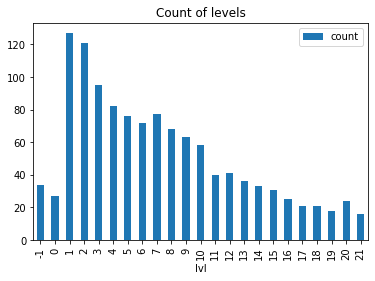

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 8
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.67
MAE: 0.47


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "basic", rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.31
RMSE test: 0.67


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

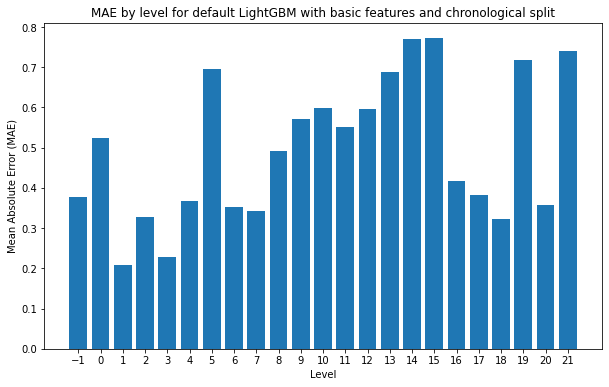

In [18]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with basic features and chronological split",
)

In [19]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Default:
RMSE: 0.67

Round type: round
RMSE: 0.71

Round type: 0.33
RMSE: 0.71

Round type: 0.45
RMSE: 0.70



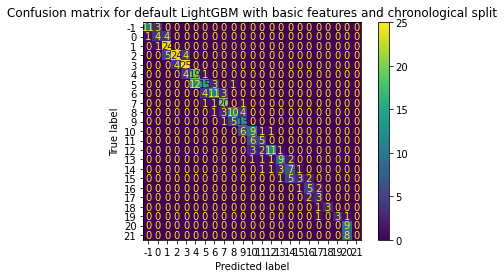

In [20]:
plot_confusion_matrix(
    "round",
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with basic features and chronological split",
)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-05 12:36:52,690] A new study created in memory with name: no-name-f26d87f4-fa9f-4cec-908f-973b3dcb9752
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.249914 + 0.0530267
[200]	cv_agg's l2: 0.236333 + 0.0541083
[300]	cv_agg's l2: 0.231615 + 0.0527245
[400]	cv_agg's l2: 0.231138 + 0.0527445


feature_fraction, val_score: 0.230179:  14%|######4                                      | 1/7 [00:03<00:21,  3.61s/it]

Early stopping, best iteration is:
[350]	cv_agg's l2: 0.230179 + 0.0518938
[100]	cv_agg's l2: 0.392932 + 0.0803017
[200]	cv_agg's l2: 0.329996 + 0.0744079
[300]	cv_agg's l2: 0.313197 + 0.0717448
[400]	cv_agg's l2: 0.303891 + 0.0672727


feature_fraction, val_score: 0.230179:  29%|############8                                | 2/7 [00:06<00:15,  3.11s/it]

Early stopping, best iteration is:
[350]	cv_agg's l2: 0.230179 + 0.0518938
[100]	cv_agg's l2: 0.272338 + 0.0616501
[200]	cv_agg's l2: 0.252749 + 0.0571439
[300]	cv_agg's l2: 0.246158 + 0.0553492


feature_fraction, val_score: 0.230179:  43%|###################2                         | 3/7 [00:08<00:09,  2.46s/it]

[400]	cv_agg's l2: 0.244178 + 0.0540519
Early stopping, best iteration is:
[350]	cv_agg's l2: 0.230179 + 0.0518938
[100]	cv_agg's l2: 0.239409 + 0.0367561
[200]	cv_agg's l2: 0.228027 + 0.0385472
[300]	cv_agg's l2: 0.224717 + 0.0402148


feature_fraction, val_score: 0.224181:  57%|#########################7                   | 4/7 [00:09<00:06,  2.04s/it]

[400]	cv_agg's l2: 0.225113 + 0.0402052
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.224181 + 0.0396265
[100]	cv_agg's l2: 0.231004 + 0.0446611
[200]	cv_agg's l2: 0.226895 + 0.0455728
[300]	cv_agg's l2: 0.228359 + 0.0457335


feature_fraction, val_score: 0.224181:  71%|################################1            | 5/7 [00:10<00:03,  1.75s/it]

[400]	cv_agg's l2: 0.229965 + 0.0464151
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.224181 + 0.0396265
[100]	cv_agg's l2: 0.234102 + 0.0514901
[200]	cv_agg's l2: 0.232555 + 0.0496004
[300]	cv_agg's l2: 0.234554 + 0.0509724


feature_fraction, val_score: 0.224181:  86%|######################################5      | 6/7 [00:12<00:01,  1.61s/it]

[400]	cv_agg's l2: 0.238073 + 0.0528597
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.224181 + 0.0396265
[100]	cv_agg's l2: 0.239409 + 0.0367561
[200]	cv_agg's l2: 0.228027 + 0.0385472
[300]	cv_agg's l2: 0.224717 + 0.0402148


feature_fraction, val_score: 0.224181: 100%|#############################################| 7/7 [00:13<00:00,  1.90s/it]


[400]	cv_agg's l2: 0.225113 + 0.0402052
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.224181 + 0.0396265


num_leaves, val_score: 0.224181:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.239409 + 0.0367561
[200]	cv_agg's l2: 0.228027 + 0.0385472
[300]	cv_agg's l2: 0.224717 + 0.0402148


num_leaves, val_score: 0.224181:   5%|##5                                               | 1/20 [00:01<00:29,  1.56s/it]

[400]	cv_agg's l2: 0.225113 + 0.0402052
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.224181 + 0.0396265
[100]	cv_agg's l2: 0.315828 + 0.0516112


num_leaves, val_score: 0.224181:   5%|##5                                               | 1/20 [00:01<00:29,  1.56s/it]

[200]	cv_agg's l2: 0.272865 + 0.0420592
[300]	cv_agg's l2: 0.257902 + 0.0388488
[400]	cv_agg's l2: 0.249642 + 0.0374136
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.224181 + 0.0396265


num_leaves, val_score: 0.224181:  10%|#####                                             | 2/20 [00:01<00:15,  1.17it/s]

[100]	cv_agg's l2: 0.239311 + 0.0358893
[200]	cv_agg's l2: 0.226819 + 0.0392133
[300]	cv_agg's l2: 0.223683 + 0.0385532
[400]	cv_agg's l2: 0.22275 + 0.0386884
[500]	cv_agg's l2: 0.222063 + 0.0386257
[600]	cv_agg's l2: 0.221209 + 0.0386381
Early stopping, best iteration is:
[596]	cv_agg's l2: 0.221103 + 0.0386581


num_leaves, val_score: 0.221103:  15%|#######5                                          | 3/20 [00:03<00:20,  1.23s/it]

[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745


num_leaves, val_score: 0.211199:  20%|##########                                        | 4/20 [00:05<00:22,  1.38s/it]

[1300]	cv_agg's l2: 0.211537 + 0.0348024
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.270492 + 0.0540263
[200]	cv_agg's l2: 0.248254 + 0.0485577
[300]	cv_agg's l2: 0.238923 + 0.0431504
[400]	cv_agg's l2: 0.232803 + 0.0403015
[500]	cv_agg's l2: 0.228421 + 0.0380934
[600]	cv_agg's l2: 0.227214 + 0.0353342
[700]	cv_agg's l2: 0.224577 + 0.0328887
[800]	cv_agg's l2: 0.223404 + 0.0304421
[900]	cv_agg's l2: 0.222487 + 0.0299471
[1000]	cv_agg's l2: 0.221594 + 0.0285819
[1100]	cv_agg's l2: 0.220623 + 0.028625


num_leaves, val_score: 0.211199:  20%|##########                                        | 4/20 [00:06<00:22,  1.38s/it]

[1200]	cv_agg's l2: 0.220208 + 0.0285321
[1300]	cv_agg's l2: 0.220069 + 0.0284517
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


num_leaves, val_score: 0.211199:  25%|############5                                     | 5/20 [00:06<00:20,  1.39s/it]

[100]	cv_agg's l2: 0.239409 + 0.0367561
[200]	cv_agg's l2: 0.228027 + 0.0385472
[300]	cv_agg's l2: 0.224717 + 0.0402148
[400]	cv_agg's l2: 0.225113 + 0.0402052
[500]	cv_agg's l2: 0.22549 + 0.0402128
[600]	cv_agg's l2: 0.227527 + 0.040631
[700]	cv_agg's l2: 0.229052 + 0.0409475
[800]	cv_agg's l2: 0.229763 + 0.0410391
[900]	cv_agg's l2: 0.230873 + 0.0412376
[1000]	cv_agg's l2: 0.231962 + 0.041447
[1100]	cv_agg's l2: 0.232916 + 0.0414216
[1200]	cv_agg's l2: 0.233823 + 0.0411989
[1300]	cv_agg's l2: 0.234745 + 0.0411125
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


num_leaves, val_score: 0.211199:  30%|###############                                   | 6/20 [00:11<00:33,  2.41s/it]

[100]	cv_agg's l2: 0.239409 + 0.0367561
[200]	cv_agg's l2: 0.228027 + 0.0385472
[300]	cv_agg's l2: 0.224717 + 0.0402148
[400]	cv_agg's l2: 0.225113 + 0.0402052
[500]	cv_agg's l2: 0.22549 + 0.0402128
[600]	cv_agg's l2: 0.227527 + 0.040631
[700]	cv_agg's l2: 0.229052 + 0.0409475
[800]	cv_agg's l2: 0.229763 + 0.0410391
[900]	cv_agg's l2: 0.230873 + 0.0412376
[1000]	cv_agg's l2: 0.231962 + 0.041447
[1100]	cv_agg's l2: 0.232916 + 0.0414216
[1200]	cv_agg's l2: 0.233823 + 0.0411989
[1300]	cv_agg's l2: 0.234745 + 0.0411125
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


num_leaves, val_score: 0.211199:  35%|#################5                                | 7/20 [00:16<00:42,  3.26s/it]

[100]	cv_agg's l2: 0.239409 + 0.0367561
[200]	cv_agg's l2: 0.228027 + 0.0385472
[300]	cv_agg's l2: 0.224717 + 0.0402148
[400]	cv_agg's l2: 0.225113 + 0.0402052
[500]	cv_agg's l2: 0.22549 + 0.0402128
[600]	cv_agg's l2: 0.227527 + 0.040631
[700]	cv_agg's l2: 0.229052 + 0.0409475
[800]	cv_agg's l2: 0.229763 + 0.0410391
[900]	cv_agg's l2: 0.230873 + 0.0412376
[1000]	cv_agg's l2: 0.231962 + 0.041447
[1100]	cv_agg's l2: 0.232916 + 0.0414216
[1200]	cv_agg's l2: 0.233823 + 0.0411989
[1300]	cv_agg's l2: 0.234745 + 0.0411125
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


num_leaves, val_score: 0.211199:  40%|####################                              | 8/20 [00:20<00:44,  3.69s/it]

[100]	cv_agg's l2: 0.366215 + 0.0669616
[200]	cv_agg's l2: 0.313697 + 0.0678043
[300]	cv_agg's l2: 0.299528 + 0.06596
[400]	cv_agg's l2: 0.295474 + 0.0662557
[500]	cv_agg's l2: 0.29316 + 0.0662927
[600]	cv_agg's l2: 0.291049 + 0.0660008
[700]	cv_agg's l2: 0.289018 + 0.0658724
[800]	cv_agg's l2: 0.287399 + 0.0656038
[900]	cv_agg's l2: 0.286056 + 0.0655589
[1000]	cv_agg's l2: 0.284919 + 0.0654125
[1100]	cv_agg's l2: 0.283908 + 0.0652385
[1200]	cv_agg's l2: 0.282784 + 0.0653983


num_leaves, val_score: 0.211199:  45%|######################5                           | 9/20 [00:21<00:31,  2.87s/it]

[1300]	cv_agg's l2: 0.281812 + 0.065332
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.239409 + 0.0367561
[200]	cv_agg's l2: 0.228027 + 0.0385472
[300]	cv_agg's l2: 0.224717 + 0.0402148
[400]	cv_agg's l2: 0.225113 + 0.0402052
[500]	cv_agg's l2: 0.22549 + 0.0402128
[600]	cv_agg's l2: 0.227527 + 0.040631
[700]	cv_agg's l2: 0.229052 + 0.0409475
[800]	cv_agg's l2: 0.229763 + 0.0410391
[900]	cv_agg's l2: 0.230873 + 0.0412376
[1000]	cv_agg's l2: 0.231962 + 0.041447
[1100]	cv_agg's l2: 0.232916 + 0.0414216
[1200]	cv_agg's l2: 0.233823 + 0.0411989
[1300]	cv_agg's l2: 0.234745 + 0.0411125
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


num_leaves, val_score: 0.211199:  50%|########################5                        | 10/20 [00:26<00:35,  3.59s/it]

[100]	cv_agg's l2: 0.239409 + 0.0367561
[200]	cv_agg's l2: 0.228027 + 0.0385472
[300]	cv_agg's l2: 0.224717 + 0.0402148
[400]	cv_agg's l2: 0.225113 + 0.0402052
[500]	cv_agg's l2: 0.22549 + 0.0402128
[600]	cv_agg's l2: 0.227527 + 0.040631
[700]	cv_agg's l2: 0.229052 + 0.0409475
[800]	cv_agg's l2: 0.229763 + 0.0410391
[900]	cv_agg's l2: 0.230873 + 0.0412376
[1000]	cv_agg's l2: 0.231962 + 0.041447
[1100]	cv_agg's l2: 0.232916 + 0.0414216
[1200]	cv_agg's l2: 0.233823 + 0.0411989
[1300]	cv_agg's l2: 0.234745 + 0.0411125


num_leaves, val_score: 0.211199:  55%|##########################9                      | 11/20 [00:32<00:36,  4.08s/it]

Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.239409 + 0.0367561
[200]	cv_agg's l2: 0.228027 + 0.0385472
[300]	cv_agg's l2: 0.224717 + 0.0402148
[400]	cv_agg's l2: 0.225113 + 0.0402052
[500]	cv_agg's l2: 0.22549 + 0.0402128
[600]	cv_agg's l2: 0.227527 + 0.040631
[700]	cv_agg's l2: 0.229052 + 0.0409475
[800]	cv_agg's l2: 0.229763 + 0.0410391
[900]	cv_agg's l2: 0.230873 + 0.0412376
[1000]	cv_agg's l2: 0.231962 + 0.041447
[1100]	cv_agg's l2: 0.232916 + 0.0414216
[1200]	cv_agg's l2: 0.233823 + 0.0411989
[1300]	cv_agg's l2: 0.234745 + 0.0411125
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


num_leaves, val_score: 0.211199:  60%|#############################4                   | 12/20 [00:37<00:36,  4.50s/it]

[100]	cv_agg's l2: 0.239409 + 0.0367561
[200]	cv_agg's l2: 0.228027 + 0.0385472
[300]	cv_agg's l2: 0.224717 + 0.0402148
[400]	cv_agg's l2: 0.225113 + 0.0402052
[500]	cv_agg's l2: 0.22549 + 0.0402128
[600]	cv_agg's l2: 0.227527 + 0.040631
[700]	cv_agg's l2: 0.229052 + 0.0409475
[800]	cv_agg's l2: 0.229763 + 0.0410391
[900]	cv_agg's l2: 0.230873 + 0.0412376
[1000]	cv_agg's l2: 0.231962 + 0.041447
[1100]	cv_agg's l2: 0.232916 + 0.0414216
[1200]	cv_agg's l2: 0.233823 + 0.0411989
[1300]	cv_agg's l2: 0.234745 + 0.0411125


num_leaves, val_score: 0.211199:  65%|###############################8                 | 13/20 [00:42<00:32,  4.70s/it]

Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.239409 + 0.0367561
[200]	cv_agg's l2: 0.228027 + 0.0385472
[300]	cv_agg's l2: 0.224717 + 0.0402148
[400]	cv_agg's l2: 0.225113 + 0.0402052
[500]	cv_agg's l2: 0.22549 + 0.0402128
[600]	cv_agg's l2: 0.227527 + 0.040631
[700]	cv_agg's l2: 0.229052 + 0.0409475
[800]	cv_agg's l2: 0.229763 + 0.0410391
[900]	cv_agg's l2: 0.230873 + 0.0412376
[1000]	cv_agg's l2: 0.231962 + 0.041447
[1100]	cv_agg's l2: 0.232916 + 0.0414216
[1200]	cv_agg's l2: 0.233823 + 0.0411989
[1300]	cv_agg's l2: 0.234745 + 0.0411125


num_leaves, val_score: 0.211199:  70%|##################################3              | 14/20 [00:48<00:30,  5.08s/it]

Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.239409 + 0.0367561
[200]	cv_agg's l2: 0.228027 + 0.0385472
[300]	cv_agg's l2: 0.224717 + 0.0402148
[400]	cv_agg's l2: 0.225113 + 0.0402052
[500]	cv_agg's l2: 0.22549 + 0.0402128
[600]	cv_agg's l2: 0.227527 + 0.040631
[700]	cv_agg's l2: 0.229052 + 0.0409475
[800]	cv_agg's l2: 0.229763 + 0.0410391
[900]	cv_agg's l2: 0.230873 + 0.0412376
[1000]	cv_agg's l2: 0.231993 + 0.0414107
[1100]	cv_agg's l2: 0.232836 + 0.041512
[1200]	cv_agg's l2: 0.233752 + 0.0412798
[1300]	cv_agg's l2: 0.234661 + 0.0412074
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


num_leaves, val_score: 0.211199:  75%|####################################7            | 15/20 [00:54<00:25,  5.19s/it]

[100]	cv_agg's l2: 0.237899 + 0.0358494
[200]	cv_agg's l2: 0.224754 + 0.0407689
[300]	cv_agg's l2: 0.222437 + 0.0413459
[400]	cv_agg's l2: 0.221991 + 0.0425618
[500]	cv_agg's l2: 0.221804 + 0.0430914
[600]	cv_agg's l2: 0.223267 + 0.0440263
[700]	cv_agg's l2: 0.224164 + 0.0441429
[800]	cv_agg's l2: 0.225441 + 0.0439995
[900]	cv_agg's l2: 0.226576 + 0.0442497
[1000]	cv_agg's l2: 0.22722 + 0.0440013
[1100]	cv_agg's l2: 0.228022 + 0.043839
[1200]	cv_agg's l2: 0.228979 + 0.0438249


num_leaves, val_score: 0.211199:  75%|####################################7            | 15/20 [00:58<00:25,  5.19s/it]

[1300]	cv_agg's l2: 0.22968 + 0.0436377
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


num_leaves, val_score: 0.211199:  80%|#######################################2         | 16/20 [00:58<00:20,  5.08s/it]

[100]	cv_agg's l2: 0.239409 + 0.0367561
[200]	cv_agg's l2: 0.228027 + 0.0385472
[300]	cv_agg's l2: 0.224717 + 0.0402148
[400]	cv_agg's l2: 0.225113 + 0.0402052
[500]	cv_agg's l2: 0.22549 + 0.0402128
[600]	cv_agg's l2: 0.227527 + 0.040631
[700]	cv_agg's l2: 0.229052 + 0.0409475
[800]	cv_agg's l2: 0.229763 + 0.0410391
[900]	cv_agg's l2: 0.230873 + 0.0412376
[1000]	cv_agg's l2: 0.231962 + 0.041447
[1100]	cv_agg's l2: 0.232916 + 0.0414216
[1200]	cv_agg's l2: 0.233823 + 0.0411989
[1300]	cv_agg's l2: 0.234745 + 0.0411125


num_leaves, val_score: 0.211199:  85%|#########################################6       | 17/20 [01:04<00:15,  5.09s/it]

Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.239409 + 0.0367561
[200]	cv_agg's l2: 0.228027 + 0.0385472
[300]	cv_agg's l2: 0.224717 + 0.0402148
[400]	cv_agg's l2: 0.225113 + 0.0402052
[500]	cv_agg's l2: 0.22549 + 0.0402128
[600]	cv_agg's l2: 0.227527 + 0.040631
[700]	cv_agg's l2: 0.229052 + 0.0409475
[800]	cv_agg's l2: 0.229763 + 0.0410391
[900]	cv_agg's l2: 0.230873 + 0.0412376
[1000]	cv_agg's l2: 0.231962 + 0.041447
[1100]	cv_agg's l2: 0.232916 + 0.0414216
[1200]	cv_agg's l2: 0.233823 + 0.0411989
[1300]	cv_agg's l2: 0.234745 + 0.0411125
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


num_leaves, val_score: 0.211199:  90%|############################################1    | 18/20 [01:09<00:10,  5.27s/it]

[100]	cv_agg's l2: 0.239409 + 0.0367561
[200]	cv_agg's l2: 0.228027 + 0.0385472
[300]	cv_agg's l2: 0.224717 + 0.0402148
[400]	cv_agg's l2: 0.225113 + 0.0402052
[500]	cv_agg's l2: 0.22549 + 0.0402128
[600]	cv_agg's l2: 0.227527 + 0.040631
[700]	cv_agg's l2: 0.229052 + 0.0409475
[800]	cv_agg's l2: 0.229763 + 0.0410391
[900]	cv_agg's l2: 0.230873 + 0.0412376
[1000]	cv_agg's l2: 0.231962 + 0.041447
[1100]	cv_agg's l2: 0.232916 + 0.0414216
[1200]	cv_agg's l2: 0.233823 + 0.0411989
[1300]	cv_agg's l2: 0.234745 + 0.0411125


num_leaves, val_score: 0.211199:  95%|##############################################5  | 19/20 [01:15<00:05,  5.45s/it]

Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.248752 + 0.0363879
[200]	cv_agg's l2: 0.23301 + 0.0345277
[300]	cv_agg's l2: 0.223657 + 0.0324262
[400]	cv_agg's l2: 0.221578 + 0.0310793
[500]	cv_agg's l2: 0.219726 + 0.0300764
[600]	cv_agg's l2: 0.218871 + 0.0301281
[700]	cv_agg's l2: 0.217191 + 0.0304786
[800]	cv_agg's l2: 0.216447 + 0.0310231
[900]	cv_agg's l2: 0.215849 + 0.0309956
[1000]	cv_agg's l2: 0.216335 + 0.0312055
[1100]	cv_agg's l2: 0.217027 + 0.0315698
[1200]	cv_agg's l2: 0.217654 + 0.0314187


num_leaves, val_score: 0.211199: 100%|#################################################| 20/20 [01:17<00:00,  3.90s/it]


[1300]	cv_agg's l2: 0.217869 + 0.0317157
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


bagging, val_score: 0.211199:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.300578 + 0.0524964
[200]	cv_agg's l2: 0.280823 + 0.0556745
[300]	cv_agg's l2: 0.271916 + 0.0551407
[400]	cv_agg's l2: 0.267784 + 0.0567175
[500]	cv_agg's l2: 0.267906 + 0.0540922
[600]	cv_agg's l2: 0.266163 + 0.0531363
[700]	cv_agg's l2: 0.264712 + 0.0518095
[800]	cv_agg's l2: 0.262773 + 0.0528802
[900]	cv_agg's l2: 0.260452 + 0.0522206
[1000]	cv_agg's l2: 0.259233 + 0.0542269
[1100]	cv_agg's l2: 0.257767 + 0.0525602
[1200]	cv_agg's l2: 0.26218 + 0.0566255


bagging, val_score: 0.211199:  10%|#####3                                               | 1/10 [00:02<00:23,  2.65s/it]

[1300]	cv_agg's l2: 0.262136 + 0.0566731
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.255069 + 0.0406809
[200]	cv_agg's l2: 0.236936 + 0.0401477
[300]	cv_agg's l2: 0.229446 + 0.0376604
[400]	cv_agg's l2: 0.222978 + 0.037332
[500]	cv_agg's l2: 0.219861 + 0.0360048
[600]	cv_agg's l2: 0.216634 + 0.0346273
[700]	cv_agg's l2: 0.214701 + 0.0348089
[800]	cv_agg's l2: 0.213244 + 0.0348683
[900]	cv_agg's l2: 0.212722 + 0.0347282
[1000]	cv_agg's l2: 0.213091 + 0.0351631
[1100]	cv_agg's l2: 0.212757 + 0.035619
[1200]	cv_agg's l2: 0.212164 + 0.0355416
[1300]	cv_agg's l2: 0.211852 + 0.0351519


bagging, val_score: 0.211199:  20%|##########6                                          | 2/10 [00:05<00:21,  2.63s/it]

Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.255026 + 0.0459838
[200]	cv_agg's l2: 0.236586 + 0.0437738
[300]	cv_agg's l2: 0.229061 + 0.0394316
[400]	cv_agg's l2: 0.222375 + 0.0369449
[500]	cv_agg's l2: 0.219542 + 0.0364599
[600]	cv_agg's l2: 0.217644 + 0.0356657
[700]	cv_agg's l2: 0.216332 + 0.0353595
[800]	cv_agg's l2: 0.214743 + 0.0353385
[900]	cv_agg's l2: 0.214654 + 0.0354506
[1000]	cv_agg's l2: 0.215243 + 0.0360985
[1100]	cv_agg's l2: 0.215337 + 0.0344736
[1200]	cv_agg's l2: 0.214523 + 0.0347394
[1300]	cv_agg's l2: 0.214383 + 0.0352071


bagging, val_score: 0.211199:  30%|###############9                                     | 3/10 [00:07<00:18,  2.60s/it]

Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.263228 + 0.0515171
[200]	cv_agg's l2: 0.240326 + 0.0484973
[300]	cv_agg's l2: 0.231549 + 0.0436118
[400]	cv_agg's l2: 0.226338 + 0.0409503
[500]	cv_agg's l2: 0.223373 + 0.038314
[600]	cv_agg's l2: 0.221375 + 0.0361574
[700]	cv_agg's l2: 0.220268 + 0.0356347
[800]	cv_agg's l2: 0.218354 + 0.0353411
[900]	cv_agg's l2: 0.216894 + 0.0353071
[1000]	cv_agg's l2: 0.216782 + 0.0350002
[1100]	cv_agg's l2: 0.216183 + 0.0353994
[1200]	cv_agg's l2: 0.215391 + 0.0342773
[1300]	cv_agg's l2: 0.215603 + 0.0343335


bagging, val_score: 0.211199:  40%|#####################2                               | 4/10 [00:10<00:16,  2.71s/it]

Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.255022 + 0.0490248
[200]	cv_agg's l2: 0.237164 + 0.0435767
[300]	cv_agg's l2: 0.228259 + 0.0380459
[400]	cv_agg's l2: 0.222078 + 0.0369935
[500]	cv_agg's l2: 0.218042 + 0.0341827
[600]	cv_agg's l2: 0.215421 + 0.0328988
[700]	cv_agg's l2: 0.214541 + 0.0339652
[800]	cv_agg's l2: 0.212929 + 0.0341967
[900]	cv_agg's l2: 0.212699 + 0.0345057
[1000]	cv_agg's l2: 0.21298 + 0.0350296
[1100]	cv_agg's l2: 0.21271 + 0.0354955
[1200]	cv_agg's l2: 0.212466 + 0.0354088


bagging, val_score: 0.211199:  50%|##########################5                          | 5/10 [00:13<00:13,  2.78s/it]

[1300]	cv_agg's l2: 0.213625 + 0.035511
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.25597 + 0.0458778
[200]	cv_agg's l2: 0.235992 + 0.0420732
[300]	cv_agg's l2: 0.227561 + 0.0407367
[400]	cv_agg's l2: 0.221706 + 0.0369822
[500]	cv_agg's l2: 0.219036 + 0.0355254
[600]	cv_agg's l2: 0.217382 + 0.0346387
[700]	cv_agg's l2: 0.215796 + 0.0346474
[800]	cv_agg's l2: 0.215041 + 0.0353886
[900]	cv_agg's l2: 0.214836 + 0.0361704
[1000]	cv_agg's l2: 0.214204 + 0.0367806
[1100]	cv_agg's l2: 0.213409 + 0.035825
[1200]	cv_agg's l2: 0.212253 + 0.0360159
[1300]	cv_agg's l2: 0.212451 + 0.0360704


bagging, val_score: 0.211199:  60%|###############################8                     | 6/10 [00:16<00:11,  2.86s/it]

Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.253057 + 0.0439603
[200]	cv_agg's l2: 0.234812 + 0.0425776
[300]	cv_agg's l2: 0.227728 + 0.040211
[400]	cv_agg's l2: 0.222397 + 0.0377536
[500]	cv_agg's l2: 0.220286 + 0.0368956
[600]	cv_agg's l2: 0.217326 + 0.0356862
[700]	cv_agg's l2: 0.216492 + 0.0355726
[800]	cv_agg's l2: 0.215779 + 0.0357989
[900]	cv_agg's l2: 0.21534 + 0.0361635
[1000]	cv_agg's l2: 0.215091 + 0.0358726
[1100]	cv_agg's l2: 0.214594 + 0.0354467
[1200]	cv_agg's l2: 0.213732 + 0.0355737


bagging, val_score: 0.211199:  70%|#####################################                | 7/10 [00:19<00:08,  2.83s/it]

[1300]	cv_agg's l2: 0.213972 + 0.0363707
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.259402 + 0.0454662
[200]	cv_agg's l2: 0.240751 + 0.0441487
[300]	cv_agg's l2: 0.232119 + 0.0414347
[400]	cv_agg's l2: 0.226995 + 0.0394438
[500]	cv_agg's l2: 0.221138 + 0.0387048
[600]	cv_agg's l2: 0.220274 + 0.0401983
[700]	cv_agg's l2: 0.2185 + 0.0388289
[800]	cv_agg's l2: 0.218907 + 0.0378653
[900]	cv_agg's l2: 0.217187 + 0.0375682
[1000]	cv_agg's l2: 0.214504 + 0.0372718
[1100]	cv_agg's l2: 0.21448 + 0.0359719
[1200]	cv_agg's l2: 0.214299 + 0.0359863


bagging, val_score: 0.211199:  70%|#####################################                | 7/10 [00:23<00:08,  2.83s/it]

[1300]	cv_agg's l2: 0.213216 + 0.0363114
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


bagging, val_score: 0.211199:  80%|##########################################4          | 8/10 [00:23<00:06,  3.26s/it]

[100]	cv_agg's l2: 0.265701 + 0.0492112
[200]	cv_agg's l2: 0.246771 + 0.0466811
[300]	cv_agg's l2: 0.237052 + 0.0429101
[400]	cv_agg's l2: 0.229547 + 0.0402664
[500]	cv_agg's l2: 0.228941 + 0.0396964
[600]	cv_agg's l2: 0.22396 + 0.0380976
[700]	cv_agg's l2: 0.220173 + 0.0352069
[800]	cv_agg's l2: 0.219197 + 0.0350783
[900]	cv_agg's l2: 0.218498 + 0.034207
[1000]	cv_agg's l2: 0.217509 + 0.0361977
[1100]	cv_agg's l2: 0.217641 + 0.0342479
[1200]	cv_agg's l2: 0.216796 + 0.0344093


bagging, val_score: 0.211199:  90%|###############################################7     | 9/10 [00:27<00:03,  3.62s/it]

[1300]	cv_agg's l2: 0.216339 + 0.0357368
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.266542 + 0.0369209
[200]	cv_agg's l2: 0.254359 + 0.0421284
[300]	cv_agg's l2: 0.244305 + 0.0387729
[400]	cv_agg's l2: 0.238914 + 0.0354451
[500]	cv_agg's l2: 0.229941 + 0.0337377
[600]	cv_agg's l2: 0.227767 + 0.0356581
[700]	cv_agg's l2: 0.225645 + 0.0340185
[800]	cv_agg's l2: 0.222767 + 0.0329124
[900]	cv_agg's l2: 0.223133 + 0.0327052
[1000]	cv_agg's l2: 0.222706 + 0.0324362
[1100]	cv_agg's l2: 0.218912 + 0.030772
[1200]	cv_agg's l2: 0.217885 + 0.029655


bagging, val_score: 0.211199:  90%|###############################################7     | 9/10 [00:32<00:03,  3.62s/it]

[1300]	cv_agg's l2: 0.216786 + 0.0312135
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


feature_fraction_stage2, val_score: 0.211199:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.271635 + 0.0575271
[200]	cv_agg's l2: 0.243446 + 0.0472042
[300]	cv_agg's l2: 0.233936 + 0.0421637
[400]	cv_agg's l2: 0.227532 + 0.0375635
[500]	cv_agg's l2: 0.223543 + 0.0356016
[600]	cv_agg's l2: 0.221944 + 0.0353237
[700]	cv_agg's l2: 0.220178 + 0.0345579
[800]	cv_agg's l2: 0.219298 + 0.0340876
[900]	cv_agg's l2: 0.218659 + 0.0338282
[1000]	cv_agg's l2: 0.217861 + 0.0341163
[1100]	cv_agg's l2: 0.218095 + 0.0346832
[1200]	cv_agg's l2: 0.217475 + 0.034319


feature_fraction_stage2, val_score: 0.211199:  17%|######3                               | 1/6 [00:03<00:19,  3.86s/it]

[1300]	cv_agg's l2: 0.217436 + 0.0340586
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745


feature_fraction_stage2, val_score: 0.211199:  33%|############6                         | 2/6 [00:07<00:15,  3.76s/it]

[1300]	cv_agg's l2: 0.211537 + 0.0348024
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745


feature_fraction_stage2, val_score: 0.211199:  50%|###################                   | 3/6 [00:11<00:11,  3.76s/it]

[1300]	cv_agg's l2: 0.211537 + 0.0348024
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745


feature_fraction_stage2, val_score: 0.211199:  67%|#########################3            | 4/6 [00:15<00:07,  3.85s/it]

[1300]	cv_agg's l2: 0.211537 + 0.0348024
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.271635 + 0.0575271
[200]	cv_agg's l2: 0.243446 + 0.0472042
[300]	cv_agg's l2: 0.233936 + 0.0421637
[400]	cv_agg's l2: 0.227532 + 0.0375635
[500]	cv_agg's l2: 0.223543 + 0.0356016
[600]	cv_agg's l2: 0.221944 + 0.0353237
[700]	cv_agg's l2: 0.220178 + 0.0345579
[800]	cv_agg's l2: 0.219298 + 0.0340876
[900]	cv_agg's l2: 0.218659 + 0.0338282
[1000]	cv_agg's l2: 0.217861 + 0.0341163
[1100]	cv_agg's l2: 0.218095 + 0.0346832
[1200]	cv_agg's l2: 0.217475 + 0.034319


feature_fraction_stage2, val_score: 0.211199:  83%|###############################6      | 5/6 [00:19<00:03,  3.86s/it]

[1300]	cv_agg's l2: 0.217436 + 0.0340586
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.271635 + 0.0575271
[200]	cv_agg's l2: 0.243446 + 0.0472042
[300]	cv_agg's l2: 0.233936 + 0.0421637
[400]	cv_agg's l2: 0.227532 + 0.0375635
[500]	cv_agg's l2: 0.223543 + 0.0356016
[600]	cv_agg's l2: 0.221944 + 0.0353237
[700]	cv_agg's l2: 0.220178 + 0.0345579
[800]	cv_agg's l2: 0.219298 + 0.0340876
[900]	cv_agg's l2: 0.218659 + 0.0338282
[1000]	cv_agg's l2: 0.217861 + 0.0341163
[1100]	cv_agg's l2: 0.218095 + 0.0346832
[1200]	cv_agg's l2: 0.217475 + 0.034319


feature_fraction_stage2, val_score: 0.211199: 100%|######################################| 6/6 [00:22<00:00,  3.83s/it]


[1300]	cv_agg's l2: 0.217436 + 0.0340586
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


regularization_factors, val_score: 0.211199:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.255471 + 0.0495396
[200]	cv_agg's l2: 0.233937 + 0.0431335
[300]	cv_agg's l2: 0.227336 + 0.04185
[400]	cv_agg's l2: 0.223879 + 0.0398738
[500]	cv_agg's l2: 0.222148 + 0.0380305
[600]	cv_agg's l2: 0.219498 + 0.0377056
[700]	cv_agg's l2: 0.219088 + 0.0375537
[800]	cv_agg's l2: 0.218236 + 0.0367309
[900]	cv_agg's l2: 0.217157 + 0.0363243
[1000]	cv_agg's l2: 0.216877 + 0.0353981
[1100]	cv_agg's l2: 0.216158 + 0.035276
[1200]	cv_agg's l2: 0.215835 + 0.0351461


regularization_factors, val_score: 0.211199:   5%|#9                                    | 1/20 [00:04<01:17,  4.08s/it]

[1300]	cv_agg's l2: 0.215687 + 0.0350546
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745
[1300]	cv_agg's l2: 0.211537 + 0.0348024
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


regularization_factors, val_score: 0.211199:  10%|###8                                  | 2/20 [00:08<01:12,  4.03s/it]

[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745


regularization_factors, val_score: 0.211199:  15%|#####7                                | 3/20 [00:12<01:09,  4.07s/it]

[1300]	cv_agg's l2: 0.211537 + 0.0348024
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745


regularization_factors, val_score: 0.211199:  20%|#######6                              | 4/20 [00:16<01:04,  4.00s/it]

[1300]	cv_agg's l2: 0.211537 + 0.0348024
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745


regularization_factors, val_score: 0.211199:  25%|#########5                            | 5/20 [00:19<00:58,  3.92s/it]

[1300]	cv_agg's l2: 0.211537 + 0.0348024
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745


regularization_factors, val_score: 0.211199:  25%|#########5                            | 5/20 [00:23<00:58,  3.92s/it]

[1300]	cv_agg's l2: 0.211537 + 0.0348024
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


regularization_factors, val_score: 0.211199:  30%|###########4                          | 6/20 [00:23<00:55,  3.94s/it]

[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745


regularization_factors, val_score: 0.211199:  35%|#############3                        | 7/20 [00:27<00:51,  3.93s/it]

[1300]	cv_agg's l2: 0.211537 + 0.0348024
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745


regularization_factors, val_score: 0.211199:  40%|###############2                      | 8/20 [00:31<00:47,  3.95s/it]

[1300]	cv_agg's l2: 0.211537 + 0.0348024
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745


regularization_factors, val_score: 0.211199:  45%|#################1                    | 9/20 [00:35<00:43,  3.91s/it]

[1300]	cv_agg's l2: 0.211537 + 0.0348024
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745
[1300]	cv_agg's l2: 0.211537 + 0.0348024
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


regularization_factors, val_score: 0.211199:  50%|##################5                  | 10/20 [00:40<00:40,  4.07s/it]

[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745


regularization_factors, val_score: 0.211199:  50%|##################5                  | 10/20 [00:44<00:40,  4.07s/it]

[1300]	cv_agg's l2: 0.211537 + 0.0348024
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


regularization_factors, val_score: 0.211199:  55%|####################3                | 11/20 [00:44<00:38,  4.28s/it]

[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745


regularization_factors, val_score: 0.211199:  55%|####################3                | 11/20 [00:49<00:38,  4.28s/it]

[1300]	cv_agg's l2: 0.211537 + 0.0348024
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


regularization_factors, val_score: 0.211199:  60%|######################2              | 12/20 [00:49<00:35,  4.38s/it]

[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745
[1300]	cv_agg's l2: 0.211537 + 0.0348024


regularization_factors, val_score: 0.211199:  65%|########################             | 13/20 [00:54<00:32,  4.70s/it]

Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745


regularization_factors, val_score: 0.211199:  65%|########################             | 13/20 [01:00<00:32,  4.70s/it]

[1300]	cv_agg's l2: 0.211537 + 0.0348024
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


regularization_factors, val_score: 0.211199:  70%|#########################9           | 14/20 [01:00<00:30,  5.01s/it]

[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745
[1300]	cv_agg's l2: 0.211537 + 0.0348024
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


regularization_factors, val_score: 0.211199:  75%|###########################7         | 15/20 [01:05<00:25,  5.03s/it]

[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745
[1300]	cv_agg's l2: 0.211537 + 0.0348024


regularization_factors, val_score: 0.211199:  80%|#############################6       | 16/20 [01:12<00:22,  5.58s/it]

Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745
[1300]	cv_agg's l2: 0.211537 + 0.0348024


regularization_factors, val_score: 0.211199:  85%|###############################4     | 17/20 [01:20<00:18,  6.21s/it]

Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745
[1300]	cv_agg's l2: 0.211537 + 0.0348024


regularization_factors, val_score: 0.211199:  90%|#################################3   | 18/20 [01:25<00:11,  5.96s/it]

Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745
[1300]	cv_agg's l2: 0.211537 + 0.0348024


regularization_factors, val_score: 0.211199:  95%|###################################1 | 19/20 [01:30<00:05,  5.80s/it]

Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635
[100]	cv_agg's l2: 0.256867 + 0.0471725
[200]	cv_agg's l2: 0.237499 + 0.0447196
[300]	cv_agg's l2: 0.225938 + 0.0412616
[400]	cv_agg's l2: 0.222166 + 0.0389536
[500]	cv_agg's l2: 0.219872 + 0.036172
[600]	cv_agg's l2: 0.218068 + 0.0353969
[700]	cv_agg's l2: 0.215884 + 0.0350071
[800]	cv_agg's l2: 0.21453 + 0.0346526
[900]	cv_agg's l2: 0.213786 + 0.0346645
[1000]	cv_agg's l2: 0.212123 + 0.0343214
[1100]	cv_agg's l2: 0.211672 + 0.0345898
[1200]	cv_agg's l2: 0.211427 + 0.0343745
[1300]	cv_agg's l2: 0.211537 + 0.0348024


regularization_factors, val_score: 0.211199: 100%|#####################################| 20/20 [01:36<00:00,  4.82s/it]


Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


min_data_in_leaf, val_score: 0.211199:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.840493 + 0.181194
[200]	cv_agg's l2: 0.820592 + 0.183215
[300]	cv_agg's l2: 0.809367 + 0.181041
[400]	cv_agg's l2: 0.800591 + 0.179001
[500]	cv_agg's l2: 0.795337 + 0.177668
[600]	cv_agg's l2: 0.791425 + 0.178162
[700]	cv_agg's l2: 0.787854 + 0.178534
[800]	cv_agg's l2: 0.785752 + 0.178507
[900]	cv_agg's l2: 0.784368 + 0.178497
[1000]	cv_agg's l2: 0.780822 + 0.178065
[1100]	cv_agg's l2: 0.780335 + 0.176797
[1200]	cv_agg's l2: 0.778935 + 0.17797
[1300]	cv_agg's l2: 0.778243 + 0.178701
Early stopping, best iteration is:
[1255]	cv_agg's l2: 0.211199 + 0.0344635


min_data_in_leaf, val_score: 0.211199:  20%|#########                                    | 1/5 [00:04<00:18,  4.65s/it]

[100]	cv_agg's l2: 0.223829 + 0.0434327
[200]	cv_agg's l2: 0.204585 + 0.0378861
[300]	cv_agg's l2: 0.199688 + 0.0339659
[400]	cv_agg's l2: 0.199126 + 0.0314648
[500]	cv_agg's l2: 0.196021 + 0.0301903
[600]	cv_agg's l2: 0.195912 + 0.0297927


min_data_in_leaf, val_score: 0.195598:  40%|##################                           | 2/5 [00:07<00:10,  3.49s/it]

Early stopping, best iteration is:
[581]	cv_agg's l2: 0.195598 + 0.0297024
[100]	cv_agg's l2: 0.223844 + 0.0463215
[200]	cv_agg's l2: 0.207975 + 0.0411181
[300]	cv_agg's l2: 0.202607 + 0.0394103
[400]	cv_agg's l2: 0.199497 + 0.0396359
[500]	cv_agg's l2: 0.196913 + 0.0390087
[600]	cv_agg's l2: 0.194958 + 0.0377766


min_data_in_leaf, val_score: 0.194780:  60%|###########################                  | 3/5 [00:10<00:06,  3.17s/it]

[700]	cv_agg's l2: 0.195111 + 0.0371896
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.19478 + 0.0375397
[100]	cv_agg's l2: 0.36522 + 0.0720522
[200]	cv_agg's l2: 0.349522 + 0.0707747
[300]	cv_agg's l2: 0.340603 + 0.0699749
[400]	cv_agg's l2: 0.336996 + 0.0707201
[500]	cv_agg's l2: 0.33439 + 0.0721289
[600]	cv_agg's l2: 0.332604 + 0.0737389


min_data_in_leaf, val_score: 0.194780:  80%|####################################         | 4/5 [00:13<00:03,  3.07s/it]

[700]	cv_agg's l2: 0.331231 + 0.0746993
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.19478 + 0.0375397
[100]	cv_agg's l2: 0.28533 + 0.0584926
[200]	cv_agg's l2: 0.268962 + 0.0558813
[300]	cv_agg's l2: 0.260596 + 0.0568839
[400]	cv_agg's l2: 0.255836 + 0.055585
[500]	cv_agg's l2: 0.250265 + 0.0527976
[600]	cv_agg's l2: 0.246617 + 0.0502365


min_data_in_leaf, val_score: 0.194780: 100%|#############################################| 5/5 [00:15<00:00,  3.16s/it]

[700]	cv_agg's l2: 0.243611 + 0.0496095
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.19478 + 0.0375397


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.19477972842145863
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.2350261194906373e-06
    lambda_l2: 6.8915222115229855e-06
    num_leaves: 6
    feature_fraction: 0.7
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.01
RMSE test: 0.66
MAE test: 0.47



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "basic",
    rmse,
    mae,
]

###### MAE by level

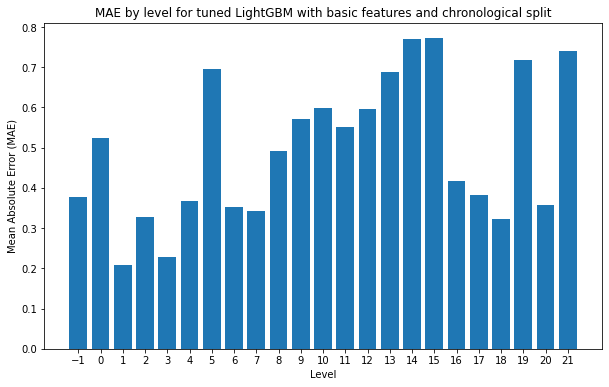

In [27]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with basic features and chronological split",
)

In [28]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.66

Round type: round
RMSE: 0.69

Round type: 0.33
RMSE: 0.69

Round type: 0.45
RMSE: 0.69



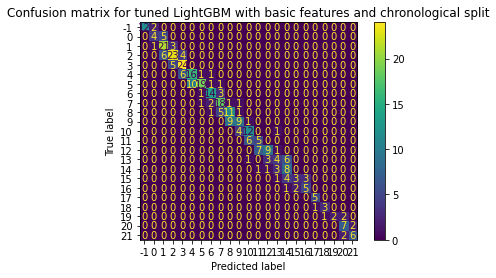

In [29]:
plot_confusion_matrix(
    "round",
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with basic features and chronological split",
)

## Random split

In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 8
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 0.243018	valid_0's l1: 0.340495


In [31]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.49
MAE: 0.34


In [33]:
results.loc[2] = ["random", "default", "basic", rmse, mae]

###### MAE by level

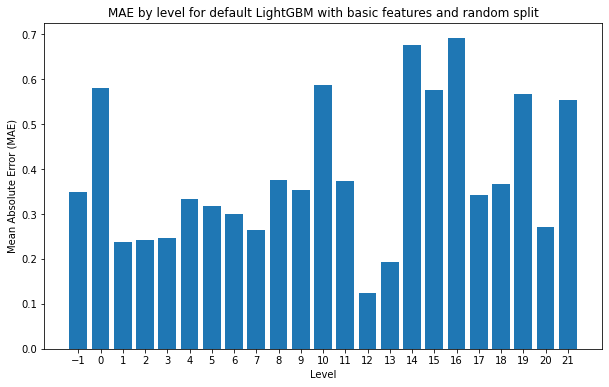

In [34]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with basic features and random split",
)

In [35]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
RMSE: 0.49

Round type: round
RMSE: 0.51

Round type: 0.33
RMSE: 0.57

Round type: 0.45
RMSE: 0.52



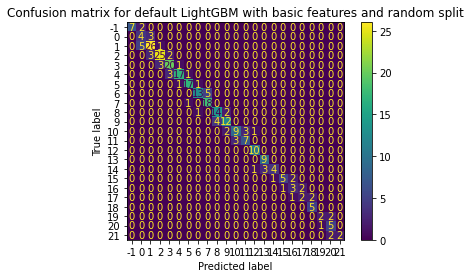

In [36]:
plot_confusion_matrix(
    "round",
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with basic features and random split",
)

### Tuning

In [37]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-05 12:41:26,269] A new study created in memory with name: no-name-d1f404fc-a876-4f8a-9133-703633223ca1
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.253669 + 0.040292
[200]	cv_agg's l2: 0.252798 + 0.040435


feature_fraction, val_score: 0.250484:  14%|######4                                      | 1/7 [00:03<00:20,  3.38s/it]

Early stopping, best iteration is:
[134]	cv_agg's l2: 0.250484 + 0.0397158
[100]	cv_agg's l2: 0.253669 + 0.040292
[200]	cv_agg's l2: 0.252798 + 0.040435


feature_fraction, val_score: 0.250484:  29%|############8                                | 2/7 [00:07<00:17,  3.57s/it]

Early stopping, best iteration is:
[134]	cv_agg's l2: 0.250484 + 0.0397158
[100]	cv_agg's l2: 0.400724 + 0.0630715
[200]	cv_agg's l2: 0.34957 + 0.0598128


feature_fraction, val_score: 0.250484:  43%|###################2                         | 3/7 [00:10<00:13,  3.40s/it]

Early stopping, best iteration is:
[134]	cv_agg's l2: 0.250484 + 0.0397158
[100]	cv_agg's l2: 0.282877 + 0.0447304
[200]	cv_agg's l2: 0.271174 + 0.0454662


feature_fraction, val_score: 0.250484:  57%|#########################7                   | 4/7 [00:13<00:09,  3.28s/it]

Early stopping, best iteration is:
[134]	cv_agg's l2: 0.250484 + 0.0397158
[100]	cv_agg's l2: 0.245015 + 0.0571001


feature_fraction, val_score: 0.244818:  71%|################################1            | 5/7 [00:16<00:06,  3.14s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.244818 + 0.0570948
[100]	cv_agg's l2: 0.258042 + 0.0766333


feature_fraction, val_score: 0.244818:  86%|######################################5      | 6/7 [00:19<00:03,  3.09s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.244818 + 0.0570948
[100]	cv_agg's l2: 0.266359 + 0.043492


feature_fraction, val_score: 0.244818: 100%|#############################################| 7/7 [00:21<00:00,  3.13s/it]


Early stopping, best iteration is:
[99]	cv_agg's l2: 0.244818 + 0.0570948


num_leaves, val_score: 0.244818:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.245015 + 0.0571001


num_leaves, val_score: 0.244818:   5%|##5                                               | 1/20 [00:02<00:52,  2.74s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.244818 + 0.0570948
[100]	cv_agg's l2: 0.245015 + 0.0571001


num_leaves, val_score: 0.244818:  10%|#####                                             | 2/20 [00:05<00:51,  2.88s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.244818 + 0.0570948
[100]	cv_agg's l2: 0.252132 + 0.0678384
[200]	cv_agg's l2: 0.243775 + 0.0652197
[300]	cv_agg's l2: 0.24312 + 0.0630787


num_leaves, val_score: 0.242371:  15%|#######5                                          | 3/20 [00:07<00:41,  2.44s/it]

[400]	cv_agg's l2: 0.243305 + 0.0595945
Early stopping, best iteration is:
[337]	cv_agg's l2: 0.242371 + 0.0609543
[100]	cv_agg's l2: 0.248779 + 0.0660306
[200]	cv_agg's l2: 0.24238 + 0.0576171


num_leaves, val_score: 0.241396:  15%|#######5                                          | 3/20 [00:09<00:41,  2.44s/it]

[300]	cv_agg's l2: 0.242091 + 0.0574278
Early stopping, best iteration is:
[237]	cv_agg's l2: 0.241396 + 0.057353


num_leaves, val_score: 0.241396:  20%|##########                                        | 4/20 [00:09<00:35,  2.22s/it]

[100]	cv_agg's l2: 0.255043 + 0.0645603
[200]	cv_agg's l2: 0.249778 + 0.0623547


num_leaves, val_score: 0.241396:  25%|############5                                     | 5/20 [00:10<00:26,  1.79s/it]

[300]	cv_agg's l2: 0.248773 + 0.0592883
Early stopping, best iteration is:
[237]	cv_agg's l2: 0.241396 + 0.057353
[100]	cv_agg's l2: 0.24458 + 0.0560947
[200]	cv_agg's l2: 0.245549 + 0.0509608
[300]	cv_agg's l2: 0.247104 + 0.0469835


num_leaves, val_score: 0.241396:  30%|###############                                   | 6/20 [00:14<00:33,  2.40s/it]

Early stopping, best iteration is:
[237]	cv_agg's l2: 0.241396 + 0.057353
[100]	cv_agg's l2: 0.245015 + 0.0571001
[200]	cv_agg's l2: 0.247879 + 0.0521112
[300]	cv_agg's l2: 0.251608 + 0.0489874


num_leaves, val_score: 0.241396:  35%|#################5                                | 7/20 [00:18<00:41,  3.17s/it]

Early stopping, best iteration is:
[237]	cv_agg's l2: 0.241396 + 0.057353
[100]	cv_agg's l2: 0.245015 + 0.0571001
[200]	cv_agg's l2: 0.247879 + 0.0521112
[300]	cv_agg's l2: 0.251608 + 0.0489874


num_leaves, val_score: 0.241396:  40%|####################                              | 8/20 [00:24<00:46,  3.91s/it]

Early stopping, best iteration is:
[237]	cv_agg's l2: 0.241396 + 0.057353
[100]	cv_agg's l2: 0.245015 + 0.0571001
[200]	cv_agg's l2: 0.247879 + 0.0521112
[300]	cv_agg's l2: 0.251608 + 0.0489874


num_leaves, val_score: 0.241396:  45%|######################5                           | 9/20 [00:29<00:48,  4.40s/it]

Early stopping, best iteration is:
[237]	cv_agg's l2: 0.241396 + 0.057353
[100]	cv_agg's l2: 0.245015 + 0.0571001
[200]	cv_agg's l2: 0.247879 + 0.0521112
[300]	cv_agg's l2: 0.251608 + 0.0489874


num_leaves, val_score: 0.241396:  50%|########################5                        | 10/20 [00:33<00:42,  4.26s/it]

Early stopping, best iteration is:
[237]	cv_agg's l2: 0.241396 + 0.057353
[100]	cv_agg's l2: 0.255043 + 0.0645603
[200]	cv_agg's l2: 0.249778 + 0.0623547


num_leaves, val_score: 0.241396:  55%|##########################9                      | 11/20 [00:34<00:29,  3.28s/it]

[300]	cv_agg's l2: 0.248773 + 0.0592883
Early stopping, best iteration is:
[237]	cv_agg's l2: 0.241396 + 0.057353
[100]	cv_agg's l2: 0.245015 + 0.0571001
[200]	cv_agg's l2: 0.247879 + 0.0521112
[300]	cv_agg's l2: 0.251608 + 0.0489874


num_leaves, val_score: 0.241396:  60%|#############################4                   | 12/20 [00:39<00:30,  3.78s/it]

Early stopping, best iteration is:
[237]	cv_agg's l2: 0.241396 + 0.057353
[100]	cv_agg's l2: 0.245015 + 0.0571001
[200]	cv_agg's l2: 0.247879 + 0.0521112
[300]	cv_agg's l2: 0.251608 + 0.0489874


num_leaves, val_score: 0.241396:  65%|###############################8                 | 13/20 [00:44<00:28,  4.01s/it]

Early stopping, best iteration is:
[237]	cv_agg's l2: 0.241396 + 0.057353
[100]	cv_agg's l2: 0.245015 + 0.0571001
[200]	cv_agg's l2: 0.247879 + 0.0521112
[300]	cv_agg's l2: 0.251608 + 0.0489874


num_leaves, val_score: 0.241396:  70%|##################################3              | 14/20 [00:48<00:24,  4.15s/it]

Early stopping, best iteration is:
[237]	cv_agg's l2: 0.241396 + 0.057353
[100]	cv_agg's l2: 0.245015 + 0.0571001
[200]	cv_agg's l2: 0.247879 + 0.0521112
[300]	cv_agg's l2: 0.251608 + 0.0489874


num_leaves, val_score: 0.241396:  75%|####################################7            | 15/20 [00:53<00:21,  4.38s/it]

Early stopping, best iteration is:
[237]	cv_agg's l2: 0.241396 + 0.057353
[100]	cv_agg's l2: 0.245015 + 0.0571001
[200]	cv_agg's l2: 0.247879 + 0.0521112
[300]	cv_agg's l2: 0.251608 + 0.0489874


num_leaves, val_score: 0.241396:  80%|#######################################2         | 16/20 [00:58<00:18,  4.51s/it]

Early stopping, best iteration is:
[237]	cv_agg's l2: 0.241396 + 0.057353
[100]	cv_agg's l2: 0.245015 + 0.0571001
[200]	cv_agg's l2: 0.247879 + 0.0521112
[300]	cv_agg's l2: 0.251608 + 0.0489874


num_leaves, val_score: 0.241396:  85%|#########################################6       | 17/20 [01:03<00:13,  4.56s/it]

Early stopping, best iteration is:
[237]	cv_agg's l2: 0.241396 + 0.057353
[100]	cv_agg's l2: 0.245015 + 0.0571001
[200]	cv_agg's l2: 0.247879 + 0.0521112
[300]	cv_agg's l2: 0.251608 + 0.0489874


num_leaves, val_score: 0.241396:  90%|############################################1    | 18/20 [01:07<00:09,  4.61s/it]

Early stopping, best iteration is:
[237]	cv_agg's l2: 0.241396 + 0.057353
[100]	cv_agg's l2: 0.245015 + 0.0571001
[200]	cv_agg's l2: 0.247879 + 0.0521112
[300]	cv_agg's l2: 0.251608 + 0.0489874


num_leaves, val_score: 0.241396:  95%|##############################################5  | 19/20 [01:12<00:04,  4.65s/it]

Early stopping, best iteration is:
[237]	cv_agg's l2: 0.241396 + 0.057353
[100]	cv_agg's l2: 0.245015 + 0.0571001
[200]	cv_agg's l2: 0.247879 + 0.0521112
[300]	cv_agg's l2: 0.251608 + 0.0489874


num_leaves, val_score: 0.241396: 100%|#################################################| 20/20 [01:17<00:00,  3.86s/it]


Early stopping, best iteration is:
[237]	cv_agg's l2: 0.241396 + 0.057353


bagging, val_score: 0.241396:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.243859 + 0.061012
[200]	cv_agg's l2: 0.239006 + 0.0563044
[300]	cv_agg's l2: 0.238532 + 0.053095


bagging, val_score: 0.237589:  10%|#####3                                               | 1/10 [00:01<00:15,  1.76s/it]

Early stopping, best iteration is:
[251]	cv_agg's l2: 0.237589 + 0.0538101
[100]	cv_agg's l2: 0.253008 + 0.0718232
[200]	cv_agg's l2: 0.244633 + 0.0657324
[300]	cv_agg's l2: 0.243182 + 0.0632022


bagging, val_score: 0.237589:  20%|##########6                                          | 2/10 [00:03<00:14,  1.75s/it]

Early stopping, best iteration is:
[251]	cv_agg's l2: 0.237589 + 0.0538101
[100]	cv_agg's l2: 0.250608 + 0.0583844
[200]	cv_agg's l2: 0.247819 + 0.0560306
[300]	cv_agg's l2: 0.248801 + 0.05319


bagging, val_score: 0.237589:  30%|###############9                                     | 3/10 [00:05<00:13,  1.86s/it]

Early stopping, best iteration is:
[251]	cv_agg's l2: 0.237589 + 0.0538101
[100]	cv_agg's l2: 0.287392 + 0.0615819
[200]	cv_agg's l2: 0.27973 + 0.0539705
[300]	cv_agg's l2: 0.279797 + 0.0523149


bagging, val_score: 0.237589:  40%|#####################2                               | 4/10 [00:07<00:11,  1.86s/it]

Early stopping, best iteration is:
[251]	cv_agg's l2: 0.237589 + 0.0538101
[100]	cv_agg's l2: 0.247365 + 0.0633493
[200]	cv_agg's l2: 0.243095 + 0.0592868
[300]	cv_agg's l2: 0.244011 + 0.0601746


bagging, val_score: 0.237589:  50%|##########################5                          | 5/10 [00:09<00:09,  1.80s/it]

Early stopping, best iteration is:
[251]	cv_agg's l2: 0.237589 + 0.0538101
[100]	cv_agg's l2: 0.248298 + 0.0646286
[200]	cv_agg's l2: 0.244496 + 0.0610033
[300]	cv_agg's l2: 0.242336 + 0.0560942


bagging, val_score: 0.237589:  60%|###############################8                     | 6/10 [00:10<00:07,  1.80s/it]

Early stopping, best iteration is:
[251]	cv_agg's l2: 0.237589 + 0.0538101
[100]	cv_agg's l2: 0.251426 + 0.0671306
[200]	cv_agg's l2: 0.248006 + 0.0565446
[300]	cv_agg's l2: 0.246711 + 0.051558


bagging, val_score: 0.237589:  70%|#####################################                | 7/10 [00:12<00:05,  1.81s/it]

Early stopping, best iteration is:
[251]	cv_agg's l2: 0.237589 + 0.0538101
[100]	cv_agg's l2: 0.250858 + 0.0652033
[200]	cv_agg's l2: 0.242377 + 0.0619267
[300]	cv_agg's l2: 0.241508 + 0.0602725


bagging, val_score: 0.237589:  80%|##########################################4          | 8/10 [00:14<00:03,  1.77s/it]

Early stopping, best iteration is:
[251]	cv_agg's l2: 0.237589 + 0.0538101
[100]	cv_agg's l2: 0.260298 + 0.05999
[200]	cv_agg's l2: 0.255639 + 0.0573603
[300]	cv_agg's l2: 0.257554 + 0.0548298


bagging, val_score: 0.237589:  90%|###############################################7     | 9/10 [00:16<00:01,  1.77s/it]

Early stopping, best iteration is:
[251]	cv_agg's l2: 0.237589 + 0.0538101
[100]	cv_agg's l2: 0.272517 + 0.0517856
[200]	cv_agg's l2: 0.263266 + 0.0519439
[300]	cv_agg's l2: 0.258641 + 0.0494925


bagging, val_score: 0.237589: 100%|####################################################| 10/10 [00:17<00:00,  1.79s/it]


Early stopping, best iteration is:
[251]	cv_agg's l2: 0.237589 + 0.0538101


feature_fraction_stage2, val_score: 0.237589:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.243268 + 0.0609296
[200]	cv_agg's l2: 0.236776 + 0.0593263
[300]	cv_agg's l2: 0.23589 + 0.0590016


feature_fraction_stage2, val_score: 0.235188:  17%|######3                               | 1/6 [00:01<00:09,  1.82s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235188 + 0.0596507
[100]	cv_agg's l2: 0.243859 + 0.061012
[200]	cv_agg's l2: 0.239006 + 0.0563044
[300]	cv_agg's l2: 0.238532 + 0.053095


feature_fraction_stage2, val_score: 0.235188:  33%|############6                         | 2/6 [00:03<00:07,  1.85s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235188 + 0.0596507
[100]	cv_agg's l2: 0.243859 + 0.061012
[200]	cv_agg's l2: 0.239006 + 0.0563044
[300]	cv_agg's l2: 0.238532 + 0.053095


feature_fraction_stage2, val_score: 0.235188:  50%|###################                   | 3/6 [00:05<00:05,  1.81s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235188 + 0.0596507
[100]	cv_agg's l2: 0.243859 + 0.061012
[200]	cv_agg's l2: 0.239006 + 0.0563044
[300]	cv_agg's l2: 0.238532 + 0.053095


feature_fraction_stage2, val_score: 0.235188:  67%|#########################3            | 4/6 [00:07<00:03,  1.81s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235188 + 0.0596507
[100]	cv_agg's l2: 0.243859 + 0.061012
[200]	cv_agg's l2: 0.239006 + 0.0563044
[300]	cv_agg's l2: 0.238532 + 0.053095


feature_fraction_stage2, val_score: 0.235188:  83%|###############################6      | 5/6 [00:09<00:01,  1.80s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235188 + 0.0596507
[100]	cv_agg's l2: 0.243268 + 0.0609296
[200]	cv_agg's l2: 0.236776 + 0.0593263
[300]	cv_agg's l2: 0.23589 + 0.0590016


feature_fraction_stage2, val_score: 0.235188: 100%|######################################| 6/6 [00:10<00:00,  1.80s/it]


Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235188 + 0.0596507


regularization_factors, val_score: 0.235188:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.249466 + 0.0560184
[200]	cv_agg's l2: 0.24349 + 0.0543023
[300]	cv_agg's l2: 0.241033 + 0.0520085


regularization_factors, val_score: 0.235188:   5%|#9                                    | 1/20 [00:01<00:34,  1.79s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235188 + 0.0596507
[100]	cv_agg's l2: 0.259256 + 0.0624894
[200]	cv_agg's l2: 0.255216 + 0.0619048


regularization_factors, val_score: 0.235188:   5%|#9                                    | 1/20 [00:03<00:34,  1.79s/it]

[300]	cv_agg's l2: 0.254194 + 0.0618867
Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235188 + 0.0596507


regularization_factors, val_score: 0.235188:  10%|###8                                  | 2/20 [00:03<00:30,  1.68s/it]

[100]	cv_agg's l2: 0.243208 + 0.0609504
[200]	cv_agg's l2: 0.236073 + 0.0585467
[300]	cv_agg's l2: 0.236814 + 0.0585493


regularization_factors, val_score: 0.235002:  15%|#####7                                | 3/20 [00:05<00:30,  1.82s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.0584452
[100]	cv_agg's l2: 0.243208 + 0.0609508
[200]	cv_agg's l2: 0.236159 + 0.0584332
[300]	cv_agg's l2: 0.236734 + 0.0576744


regularization_factors, val_score: 0.235002:  20%|#######6                              | 4/20 [00:07<00:29,  1.86s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.0584452
[100]	cv_agg's l2: 0.243208 + 0.0609505
[200]	cv_agg's l2: 0.236073 + 0.0585467
[300]	cv_agg's l2: 0.236503 + 0.0589212


regularization_factors, val_score: 0.235002:  25%|#########5                            | 5/20 [00:09<00:27,  1.85s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.0584452
[100]	cv_agg's l2: 0.243208 + 0.0609503
[200]	cv_agg's l2: 0.236073 + 0.0585466
[300]	cv_agg's l2: 0.236815 + 0.0585493


regularization_factors, val_score: 0.235002:  30%|###########4                          | 6/20 [00:10<00:25,  1.83s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.0584452
[100]	cv_agg's l2: 0.243207 + 0.0609502
[200]	cv_agg's l2: 0.236072 + 0.0585465
[300]	cv_agg's l2: 0.236814 + 0.0585492


regularization_factors, val_score: 0.235002:  35%|#############3                        | 7/20 [00:12<00:24,  1.87s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.058445
[100]	cv_agg's l2: 0.243208 + 0.0609504
[200]	cv_agg's l2: 0.236073 + 0.0585467
[300]	cv_agg's l2: 0.236503 + 0.0589212


regularization_factors, val_score: 0.235002:  40%|###############2                      | 8/20 [00:14<00:22,  1.88s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.058445
[100]	cv_agg's l2: 0.243208 + 0.0609504
[200]	cv_agg's l2: 0.236073 + 0.0585466
[300]	cv_agg's l2: 0.236814 + 0.0585493


regularization_factors, val_score: 0.235002:  45%|#################1                    | 9/20 [00:16<00:21,  1.94s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.058445
[100]	cv_agg's l2: 0.243208 + 0.0609503
[200]	cv_agg's l2: 0.236073 + 0.0585465
[300]	cv_agg's l2: 0.236815 + 0.0585492


regularization_factors, val_score: 0.235002:  50%|##################5                  | 10/20 [00:18<00:19,  1.91s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.058445
[100]	cv_agg's l2: 0.243208 + 0.0609503
[200]	cv_agg's l2: 0.236072 + 0.0585466
[300]	cv_agg's l2: 0.236814 + 0.0585492


regularization_factors, val_score: 0.235002:  55%|####################3                | 11/20 [00:20<00:16,  1.88s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.058445
[100]	cv_agg's l2: 0.243207 + 0.0609503
[200]	cv_agg's l2: 0.236072 + 0.0585465
[300]	cv_agg's l2: 0.236814 + 0.0585492


regularization_factors, val_score: 0.235002:  60%|######################2              | 12/20 [00:22<00:14,  1.85s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.058445
[100]	cv_agg's l2: 0.243208 + 0.0609505
[200]	cv_agg's l2: 0.236658 + 0.0583691
[300]	cv_agg's l2: 0.236584 + 0.0589007


regularization_factors, val_score: 0.235002:  65%|########################             | 13/20 [00:24<00:12,  1.83s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.058445
[100]	cv_agg's l2: 0.243207 + 0.0609501
[200]	cv_agg's l2: 0.236072 + 0.0585463
[300]	cv_agg's l2: 0.236814 + 0.0585491


regularization_factors, val_score: 0.235002:  70%|#########################9           | 14/20 [00:25<00:10,  1.82s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.0584449
[100]	cv_agg's l2: 0.245407 + 0.0603492
[200]	cv_agg's l2: 0.23984 + 0.05723
[300]	cv_agg's l2: 0.240487 + 0.057994


regularization_factors, val_score: 0.235002:  75%|###########################7         | 15/20 [00:27<00:09,  1.81s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.0584449
[100]	cv_agg's l2: 0.246385 + 0.0622108
[200]	cv_agg's l2: 0.241592 + 0.060769
[300]	cv_agg's l2: 0.241936 + 0.0610859


regularization_factors, val_score: 0.235002:  80%|#############################6       | 16/20 [00:29<00:07,  1.85s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.0584449
[100]	cv_agg's l2: 0.243269 + 0.0609296
[200]	cv_agg's l2: 0.236776 + 0.0593264
[300]	cv_agg's l2: 0.236406 + 0.0583846


regularization_factors, val_score: 0.235002:  85%|###############################4     | 17/20 [00:31<00:05,  1.88s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.0584449
[100]	cv_agg's l2: 0.246421 + 0.06007
[200]	cv_agg's l2: 0.24268 + 0.0598525
[300]	cv_agg's l2: 0.24247 + 0.0580701


regularization_factors, val_score: 0.235002:  90%|#################################3   | 18/20 [00:33<00:03,  1.94s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.0584449
[100]	cv_agg's l2: 0.242852 + 0.0602619
[200]	cv_agg's l2: 0.238442 + 0.0595356
[300]	cv_agg's l2: 0.23743 + 0.0585858


regularization_factors, val_score: 0.235002:  95%|###################################1 | 19/20 [00:36<00:02,  2.25s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.0584449
[100]	cv_agg's l2: 0.245043 + 0.0607077
[200]	cv_agg's l2: 0.23835 + 0.0584946
[300]	cv_agg's l2: 0.240256 + 0.0584354


regularization_factors, val_score: 0.235002: 100%|#####################################| 20/20 [00:39<00:00,  1.96s/it]


Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.0584449


min_data_in_leaf, val_score: 0.235002:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.842479 + 0.0603989
[200]	cv_agg's l2: 0.809987 + 0.0713277
[300]	cv_agg's l2: 0.792807 + 0.0762008


min_data_in_leaf, val_score: 0.235002:  20%|#########                                    | 1/5 [00:01<00:06,  1.73s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.0584449
[100]	cv_agg's l2: 0.335844 + 0.0744422
[200]	cv_agg's l2: 0.330989 + 0.0730314
[300]	cv_agg's l2: 0.331988 + 0.0708784


min_data_in_leaf, val_score: 0.235002:  40%|##################                           | 2/5 [00:03<00:05,  1.88s/it]

Early stopping, best iteration is:
[255]	cv_agg's l2: 0.235002 + 0.0584449
[100]	cv_agg's l2: 0.227076 + 0.0588067
[200]	cv_agg's l2: 0.219031 + 0.055065
[300]	cv_agg's l2: 0.217249 + 0.0524465


min_data_in_leaf, val_score: 0.216179:  60%|###########################                  | 3/5 [00:06<00:04,  2.15s/it]

[400]	cv_agg's l2: 0.217525 + 0.0496552
Early stopping, best iteration is:
[328]	cv_agg's l2: 0.216179 + 0.0503731
[100]	cv_agg's l2: 0.230437 + 0.0599331
[200]	cv_agg's l2: 0.228286 + 0.0584276
[300]	cv_agg's l2: 0.227571 + 0.0554854


min_data_in_leaf, val_score: 0.216179:  80%|####################################         | 4/5 [00:08<00:02,  2.24s/it]

[400]	cv_agg's l2: 0.227576 + 0.0542774
Early stopping, best iteration is:
[328]	cv_agg's l2: 0.216179 + 0.0503731
[100]	cv_agg's l2: 0.266075 + 0.0624023
[200]	cv_agg's l2: 0.262197 + 0.0619863
[300]	cv_agg's l2: 0.260346 + 0.0612717


min_data_in_leaf, val_score: 0.216179: 100%|#############################################| 5/5 [00:11<00:00,  2.23s/it]

[400]	cv_agg's l2: 0.262558 + 0.0630713
Early stopping, best iteration is:
[328]	cv_agg's l2: 0.216179 + 0.0503731


In [38]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.21617946864577023
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.00020278433747537158
    lambda_l2: 0.001580341009540121
    num_leaves: 8
    feature_fraction: 0.9799999999999999
    bagging_fraction: 0.9615246764400154
    bagging_freq: 1
    min_child_samples: 5


In [39]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [40]:
rmse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.51
MAE test: 0.33



In [41]:
results.loc[3] = ["random", "Optuna", "basic", rmse, mae]

###### MAE by level

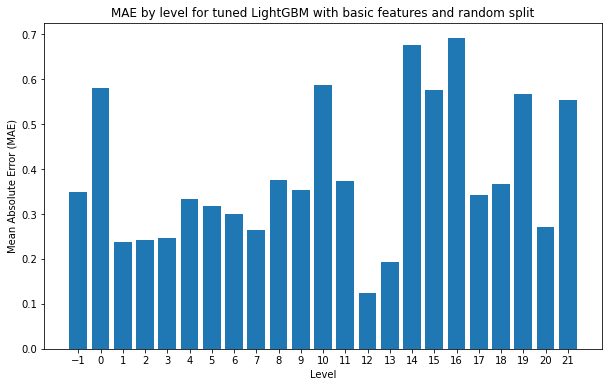

In [42]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with basic features and random split",
)

In [43]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.33

Round type: round
RMSE: 0.36

Round type: 0.33
RMSE: 0.37

Round type: 0.45
RMSE: 0.36



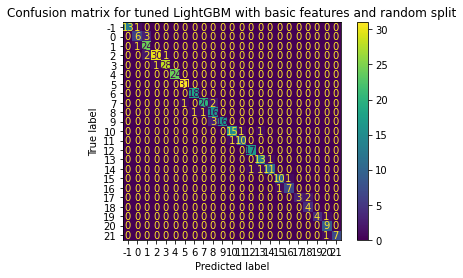

In [44]:
plot_confusion_matrix(
    "round",
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with basic features and random split",
)

## Summary

In [45]:
results

,Split type,Tuning type,Set of features,RMSE,MAE
0,chronological,default,basic,0.669004,0.467604
1,chronological,Optuna,basic,0.662849,0.469260
2,random,default,basic,0.492968,0.340495
3,random,Optuna,basic,0.506014,0.328767


In [46]:
from training.results import plot_summary

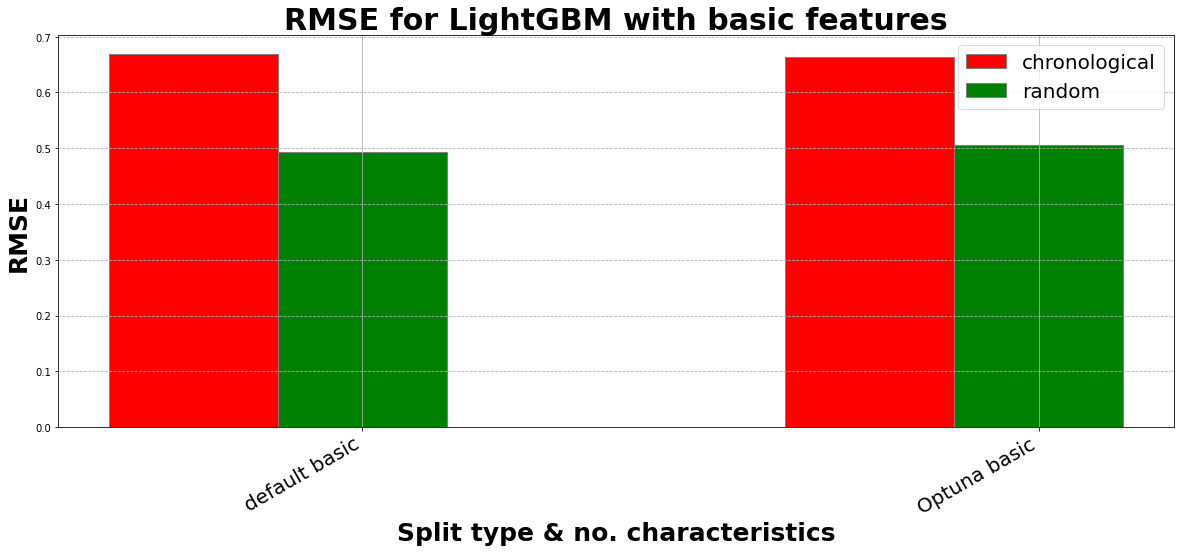

In [47]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with basic features")

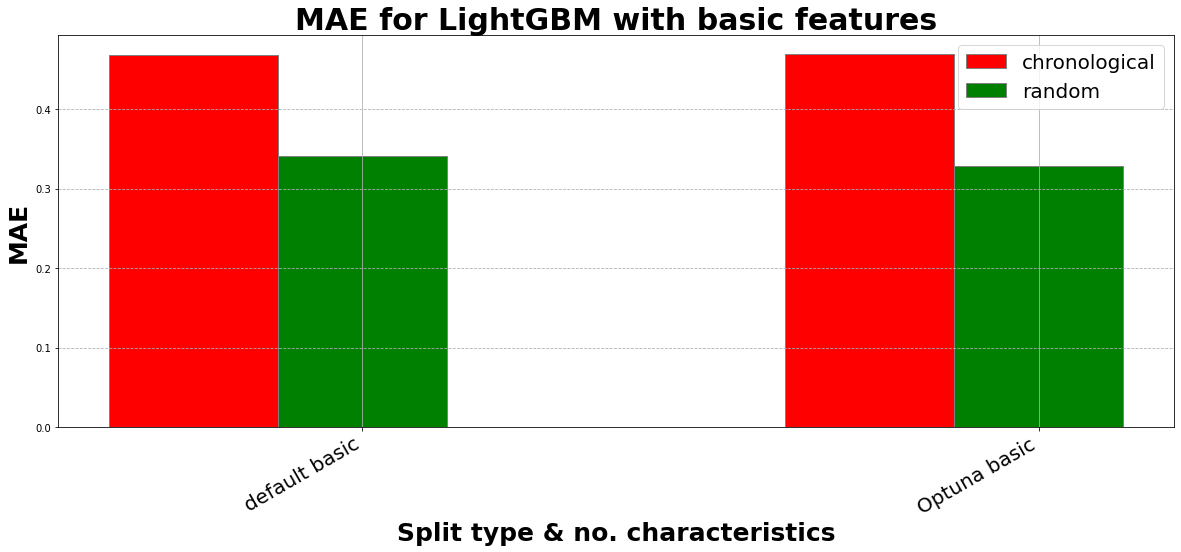

In [48]:
plot_summary(results, "MAE", title="MAE for LightGBM with basic features")

In [49]:
results.to_json("./lightgbm_basic_results.json", indent=2)